### General advice (delete this cell before submitting for review)

> * Remove the "**Sign up to the DEA Sandbox** to run this notebook interactively from a browser" header text if the notebook is not DEA Sandbox-compatible or if it is not synced to the DEA Sandbox (e.g. `Scientific_workflows` notebooks)
> * Update the **Compatibility** line depending on whether the notebook is compatible with the `NCI` and `DEA Sandbox` environments (e.g. "Notebook currently compatible with the `DEA Sandbox` environment only" or "Notebook currently compatible with the `NCI` environment only")
> * When adding **Products used**, embed the hyperlink to that specific product on the DEA Explorer using the `[product_name](product url)` syntax.
> * When writing in Markdown cells, start each sentence on a **new line**.
This makes it easy to see changes through git commits.
> * Use Australian English in markdown cells and code comments.
> * Check the [known issues](https://github.com/GeoscienceAustralia/dea-docs/wiki/Known-issues) for formatting regarding the conversion of notebooks to DEA docs using Sphinx.
Things to be aware of:
    * Sphinx is highly sensitive to bulleted lists:
        * Ensure that there is an empty line between any preceding text and the list
        * Only use the `*` bullet (`-` is not recognised)
        * Sublists must be indented by 4 spaces
    * Two kinds of formatting cannot be used simultaneously:
        * Hyperlinked code: \[\`code_format\`](hyperlink) fails
        * Bolded code: \*\*\`code_format\`\*\* fails
    * Headers must appear in heirachical order (`#`, `##`, `###`, `####`) and there can only be one title (`#`).
> * Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
> * For additional guidance, refer to the style conventions and layouts in approved `develop` branch notebooks. 
Examples include
    * [Frequently_used_code/Using_load_ard.ipynb](./Frequently_used_code/Using_load_ard.ipynb)
    * [Real_world_examples/Coastal_erosion.ipynb](./Real_world_examples/Coastal_erosion.ipynb)
    * [Scripts/dea_datahandling.py](./Scripts/dea_datahandling.py)
> * In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case (unless the tag is an acronym), separate words with spaces (unless it is the name of an imported module), and [re-use existing tags](https://github.com/GeoscienceAustralia/dea-notebooks/wiki/List-of-tags).
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


# GA Implementation of a National-Scale Random Forest Burnt Area Algorithm  <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with specific `DEA Dev Sandbox` environment: HNRS test
* **Products used:** 
[ga_ls8c_nbart_gm_4fyear_3](http://dea-public-data-dev.s3-website-ap-southeast-2.amazonaws.com/?prefix=projects/burn_cube/)
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** run in the HNRS test DEA dev sandbox environment
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
As part of the ARDC Bushfire Data Challenge, this notebook was developed to create demonstration-only burnt area products to assess the suitability of Random Forest burnt area approaches to continental-scale burnt area mapping.

The model used below was created and trained independently by GA, but where appropriate is adapted from the Victorian DELWP burnt severity Random Forest modeling approach. 

The model was trained using ARDC data across 21 AU 30 grid tiles for the 2020 Calendar year. Pre-fire indices are calculated using a four-year geomedian product, and post-fire indices are calculated using the 2020 annual geomedian product. 

A non-spectral feature layer has also been used in this model to help facilitate mapping across diverse fire regimes. A climate layer containing 3 classes (Temperate, Arid, and Tropical) has been one-hot encoded as three binary feature layers to attempt to account for the varying spectral signal of burnt area across diverse landscapes.

## Description
This notebook runs on Landsat 8, 7, and 5 data, mapping burnt areas using a range of change metrics. These are delta normalised burn ratio, delta bare soil index, and delta normalised vegetation difference index.

We use these with a 4 year geomedian from before the fire season and then data from the fire season.

1. Loading the geometry and EO data
2. Open the Koppen climate geotiff as an xr dataset
3. Applying the model to the selected tile
4. Post-processing to remove returns over water bodies and noise 
5. Export the data

***

## Getting started

To run this notebook you need to be in a HNRS sandbox environment, so that you can access the 4 year geomedians which are not stored in a public folder as they are an intermediate product purely for running analysis.

Alternatively, HNRS data can be accessed in the default sandbox environment on a user account with the required permissions.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline

import os
import datacube
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray
import rasterio.features
import rioxarray
import sys

sys.path.insert(1, "../../Tools/")

from dea_tools.plotting import rgb
from dea_tools.datahandling import load_ard
from skimage import morphology
from scipy import ndimage
from shapely.geometry import shape
from shapely.geometry import Polygon
from datacube.utils.geometry import Geometry, CRS
from datacube.utils.cog import write_cog
from odc.dscache.tools.tiling import parse_gridspec_with_name
from typing import List, Tuple

from joblib import load
from dea_tools.bandindices import calculate_indices
from dea_tools.classification import predict_xr
from dea_tools.dask import create_local_dask_cluster
from odc.algo import int_geomedian
from skimage import morphology

Setting up the notebook to access the correct path for the data (using
 the HNRS test environment in DEA dev sandbox) by setting up the configs

In [2]:
# the normal config
odc_config = {
    "db_hostname": "",
    "db_password": "",
    "db_username": "sandbox_reader",
    "db_database": "odc",
}

In [3]:
# the special config for our multi year geomedian
hnrs_config = {
    "db_hostname": "",
    "db_password": "",
    "db_username": "hnrs_dc_reader",
    "db_database": "hnrs_dc",
}

In [4]:
# need to set the AWS login so that we can access the data we need
os.environ["AWS_NO_SIGN_REQUEST"] = "Yes"

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name. This connects us to the 2 s3 buckets we need to access, because our multi year geomedians are saved in a different location.

In [5]:
# this is how we will access the normal data and get our results from the time of the
# fire and post fire 
dc = datacube.Datacube(app="post", config=odc_config)


In [6]:
# this is how we get the multi year geomedian to use as our pre-fire data
hnrs_dc = datacube.Datacube(app="geomed_loading", config=hnrs_config)

### Analysis parameters

This notebook is set up to run a whole tile area, so from the AU30 grid, select the tile name that you are after e.g. "x32y15"

* `xy`: A string containing the name of the tile you would like to investigate (e.g. `"x32y15"`). 



In [7]:
xy = 'x20y18'

## 1. Loading the geometry and EO data

Now that we have selected our area of interest (tile) we can load it in. To do this we need to get the polygon that we can then feed into `dc.load` and `load_ard`.

> **Note:** Use this markdown format (sparingly) to draw particular attention to an important point or caveat

In [8]:
def _get_gpgon(
    region_id: str,
) -> Tuple[datacube.utils.geometry.Geometry, datacube.utils.geometry._base.GeoBox]:
    """
    Get a geometry that covers the specified region for use with datacube.load().

    Parameters
    ----------
    region_id : str
        The ID of the region to get a geometry for. E.g. x30y29

    Returns
    -------
    Tuple[datacube.utils.geometry.Geometry, datacube.utils.geometry._base.GeoBox]
        The geometry object representing the region specified by `region_id` and the corresponding geobox.
    """

    _, gridspec = parse_gridspec_with_name("au-30")

    # gridspec : au-30
    pattern = r"x(\d+)y(\d+)"

    match = re.match(pattern, region_id)

    if match:
        x = int(match.group(1))
        y = int(match.group(2))
    else:
        logger.error(
            "No match found in region id %s.",
            region_id,
        )
        # cannot extract geobox, so we stop here.
        # if we throw exception, it will trigger the Airflow/Argo retry.
        sys.exit(0)

    geobox = gridspec.tile_geobox((x, y))

    # Return the resulting Geometry object
    return datacube.utils.geometry.Geometry(geobox.extent.geom, crs="epsg:3577"), geobox

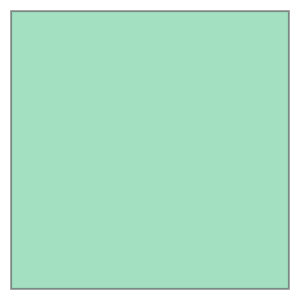

In [9]:
# running the polygon function, and getting a usable polygon out
box = _get_gpgon(xy)
pgon = box[0]
pgon

Load in the 4 (financial or calendar) year geomedian, this is our *Pre Fire Data*.
Use `ga_ls8c_nbart_gm_4cyear_3` for calendar year or `ga_ls8c_nbart_gm_4fyear_3` for financial year. 

This step is not required to process the selected tile, but provides a visual inspection of the pre-fire data and ensures that access to the HNRS environment is working as intended.

In [10]:
# PRE FIRE DATA
# load in the 4 (financial or calendar) year geomedian
ds = hnrs_dc.load(
    product="ga_ls8c_nbart_gm_4cyear_3",
    # x=(136.5, 137.5),
    # y=(-35.6, -36.1),
    geopolygon=pgon,
    time=("2017-01-01", "2017-12-31"),  # calendar year
    # time=("2016-07-01", "2019-06-30"), #financial year
    output_crs="EPSG:3577",
)

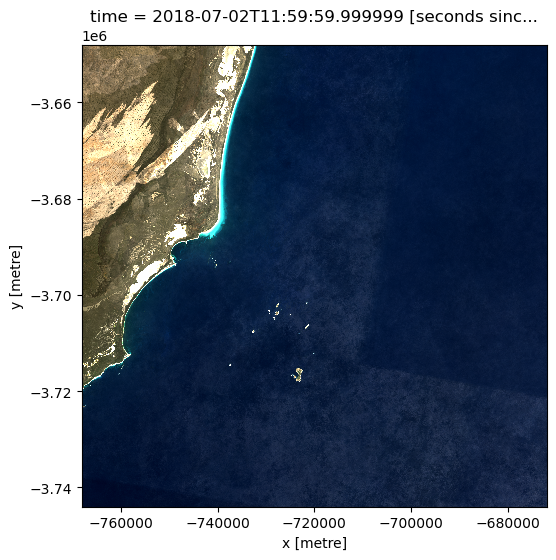

In [11]:
# check the loaded area by plotting it
rgb(ds, bands=["red", "green", "blue"], index=0)

## 2. Open the Koppen climate geotiff as an xr dataset ##
Read in the 3-class Koppen-geiger climate raster data to a analysis read xarray dataset.

In [12]:
# Define the name of the Koppen climate GeoTIFF file
geotiff_fname = "remapped_koppen_data_3classes_3577.tif"

# Open the GeoTIFF file using xarray's open_rasterio function.
climate_dataset = xr.open_rasterio(geotiff_fname)

# Convert the opened raster data into an xarray dataset, where each band becomes a variable.
climate_dataset = climate_dataset.to_dataset("band")

# Rename variable 1 to 'climate_code' for clarity and easier access.
climate_dataset = climate_dataset.rename({1: "climate_code"})

# Return the resulting xarray dataset.
climate_dataset

/tmp/ipykernel_451/1421367482.py:5: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  climate_dataset = xr.open_rasterio(geotiff_fname)


<xarray.Dataset>
Dimensions:       (y: 4259, x: 5326)
Coordinates:
  * y             (y) float64 -1.049e+06 -1.05e+06 ... -5.083e+06 -5.084e+06
  * x             (x) float64 -2.468e+06 -2.467e+06 ... 2.578e+06 2.579e+06
Data variables:
    climate_code  (y, x) int32 ...
Attributes:
    transform:      (947.6899957428166, 0.0, -2468169.1005624416, 0.0, -947.6...
    crs:            +init=epsg:3577
    res:            (947.6899957428166, 947.6899957428164)
    is_tiled:       1
    nodatavals:     (2147483647.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic

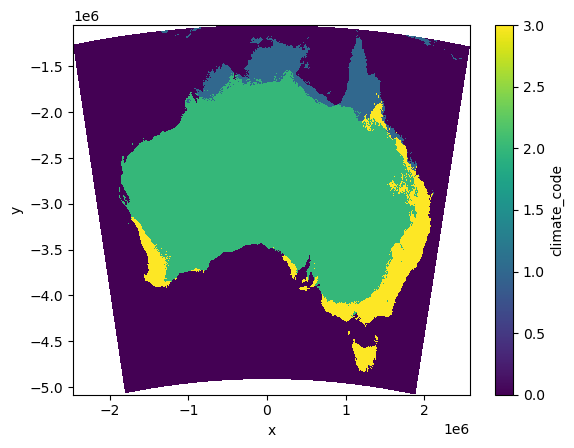

In [13]:
# Filter the climate_dataset to exclude values equal to 2147483647 (a commonly used NoData value).
climate_dataset = climate_dataset.where(climate_dataset["climate_code"] != 2147483647)

# Plot the 'climate_code' variable from the filtered dataset.
climate_dataset.climate_code.plot()

## 3. Applying the model to the selected tile

In [14]:
# Create dask cluster
create_local_dask_cluster(spare_mem="2Gb")
dask_chunks = {"x": 1000, "y": 1000}

# Set Results folder
results = "results/"

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/matthew.ellis@ga.gov.au/proxy/8787/status,
Dashboard: /user/matthew.ellis@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 7,Total memory: 60.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45547,Workers: 1
Dashboard: /user/matthew.ellis@ga.gov.au/proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 60.14 GiB
Comm: tcp://127.0.0.1:38281,Total threads: 7
Dashboard: /user/matthew.ellis@ga.gov.au/proxy/32901/status,Memory: 60.14 GiB
Nanny: tcp://127.0.0.1:46083,


#### Loading the previously trained model ####
The model file used to process the data can be accessed from the following AWS S3 storage bucket. Download the `RF_model_21_tiles_1000m_grid_3000m_to_7000m_buffer.joblib` model file [from this directory](http://dea-public-data-dev.s3-website-ap-southeast-2.amazonaws.com/?prefix=projects/burn_cube/configs/), and set the file path to the `model_path` variable below.

Details on how this model was trained can be found in the accompanying ARDC Work Package 5 report.

In [15]:
# Define the path to the saved machine learning model file.
model_path = "RF_model_21_tiles_1000m_grid_3000m_to_7000m_buffer.joblib"

# Load the machine learning model from the specified file using the `load` function from the `joblib` library.
model = load(model_path)

In [16]:
# Define the resolution of the geospatial data.
resolution = (-30, 30)

# Define the output coordinate reference system (CRS).
output_crs = "epsg:3577"

# Define a list of bands to load
measurements = ["blue", "green", "red", "nir", "swir1", "swir2"]

In [17]:
# Define the analysis year
time_post = "2020"

# Create a dictionary query object to pass to the `feature_layers` function
query = {
    "resolution": resolution,
    "output_crs": output_crs,
    "measurements": measurements,
    "geopolygon": pgon,
}

In [18]:
# Define the feature_layers function
# This function generates the data required by the RF model to map burnt area
def feature_layers(query):
    # Load ls8 4-year geomedian for the specified time period and query parameters
    ds_base = hnrs_dc.load(
        product="ga_ls8c_nbart_gm_4cyear_3",
        time=("2017-01-01", "2017-12-31"),  # calendar year
        **query
    )

    # Load post-fire annual geomedian
    ds_post = dc.load("ga_ls8c_nbart_gm_cyear_3", time=time_post, **query)

    # Calculate band indices for pre and post-fire data
    # Calculate the base(pre) indices
    da_base = calculate_indices(
        ds_base, index=["NDVI", "NBR", "NDMI"], drop=False, collection="ga_gm_3"
    )
    da_base["VARI_pre"] = (ds_base.green - ds_base.red) / (
        ds_base.green + ds_base.red - ds_base.blue
    )

    # Renaming these indices for clarity with '_pre' suffixes
    da_base = da_base.rename({"NDVI": "NDVI_pre", "NDMI": "NDMI_pre", "NBR": "NBR_pre"})

    # Calculate the post indices
    da_post = calculate_indices(
        ds_post, index=["NDVI", "NBR", "NDMI"], drop=False, collection="ga_ls_3"
    )
    da_post["VARI_post"] = (ds_post.green - ds_post.red) / (
        ds_post.green + ds_post.red - ds_post.blue
    )
    da_post["BAI_post"] = 1 / (((0.1 - ds_post.red) ** 2) + ((0.06 - ds_post.nir) ** 2))
    # Renaming these indices for clarity with '_post' suffixes
    da_post = da_post.rename(
        {"NDVI": "NDVI_post", "NDMI": "NDMI_post", "NBR": "NBR_post"}
    )

    # Calculate differences in some indices between pre and post-fire data
    dNDVI = da_base.NDVI_pre.isel(time=0) - da_post.NDVI_post
    dNDVI = dNDVI.rename("dNDVI")
    dNBR = da_base.NBR_pre.isel(time=0) - da_post.NBR_post
    dNBR = dNBR.rename("dNBR")
    dNDMI = da_base.NDMI_pre.isel(time=0) - da_post.NDMI_post
    dNDMI = dNDMI.rename("dNDMI")
    dVARI = da_base.VARI_pre.isel(time=0) - da_post.VARI_post
    dVARI = dVARI.rename("dVARI")

    # Remove unnecessary variables from the datasets
    drop_list = ["green", "red", "blue", "nir", "swir1", "swir2"]
    da_base = da_base.drop_vars(drop_list)
    da_base = da_base.isel(time=0)
    da_base = da_base.drop_vars("time")
    da_post = da_post.drop_vars(drop_list)

    # Extract climate data based on the specified geographical polygon (query_pgon)
    query_pgon = query["geopolygon"]
    x_range = query_pgon.boundingbox.range_x
    y_range = query_pgon.boundingbox.range_y
    ds_climate = climate_dataset.sel(
        x=slice(x_range[0], x_range[1]), y=slice(y_range[1], y_range[0])
    )

    # Reproject the climate data to match the post-fire data's CRS
    da_post = da_post.rio.write_crs("EPSG:3577")
    ds_climate = ds_climate.rio.write_crs("EPSG:3577")
    ds_climate = ds_climate.rio.reproject_match(da_post)

    # Create new climate code variables based on the value of 'climate_code'
    ds_climate["climate_code_1"] = ds_climate["climate_code"] * 0
    ds_climate["climate_code_2"] = ds_climate["climate_code"] * 0
    ds_climate["climate_code_3"] = ds_climate["climate_code"] * 0

    ds_climate["climate_code_1"] = xr.where(
        ds_climate["climate_code"] == 1, 1, ds_climate["climate_code_1"]
    )
    ds_climate["climate_code_2"] = xr.where(
        ds_climate["climate_code"] == 2, 1, ds_climate["climate_code_2"]
    )
    ds_climate["climate_code_3"] = xr.where(
        ds_climate["climate_code"] == 3, 1, ds_climate["climate_code_3"]
    )

    # Drop the original 'climate_code' variable
    ds_climate = ds_climate.drop_vars("climate_code")

    # Merge all the datasets into a single result dataset
    result = xr.merge(
        [da_post, da_base, dNBR, dNDVI, dVARI, dNDMI, ds_climate], compat="override"
    )

    return result

In [19]:
# Generate a dataset using the feature_layers function based on the 'query' configuration
data = feature_layers(query).squeeze()
data

<xarray.Dataset>
Dimensions:         (y: 3200, x: 3200)
Coordinates:
    time            datetime64[ns] 2020-07-01T23:59:59.999999
  * y               (y) float64 -3.648e+06 -3.648e+06 ... -3.744e+06 -3.744e+06
  * x               (x) float64 -7.68e+05 -7.68e+05 ... -6.72e+05 -6.72e+05
    spatial_ref     int64 0
Data variables: (12/16)
    NDVI_post       (y, x) float64 0.275 0.287 0.3042 ... -0.08816 -0.08906
    NBR_post        (y, x) float64 -0.09314 -0.08443 -0.0751 ... 0.1456 0.1438
    NDMI_post       (y, x) float64 -0.1706 -0.1748 -0.1799 ... 0.08383 0.08157
    VARI_post       (y, x) float64 -0.1201 -0.1118 -0.1065 ... 1.197 1.217 1.304
    BAI_post        (y, x) float64 3.134e-07 3.763e-07 ... 1.26e-05 1.286e-05
    NDVI_pre        (y, x) float64 0.3761 0.415 0.4327 ... -0.04873 -0.05727
    ...              ...
    dNDVI           (y, x) float64 0.1011 0.128 0.1285 ... 0.03943 0.03179
    dVARI           (y, x) float64 -0.005499 0.003659 ... -0.7587 -0.6014
    dNDMI           (y, x) float64 0.03146 0.05532 0.0721 ... -0.0543 -0.04021
    climate_code_1  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    climate_code_2  (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    climate_code_3  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

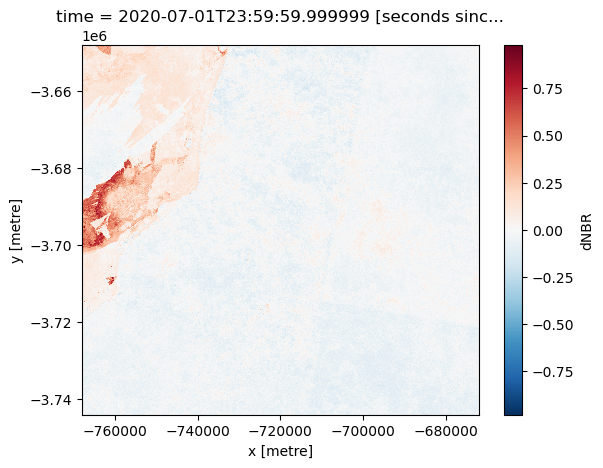

In [20]:
#PLot the dNBR index
data["dNBR"].plot()

In [21]:
# Call the `predict_xr` function on the data variable to run the RF model
predicted = predict_xr(model,
                       data,
                       proba=True,
                       persist=True,
                       clean=True,
                       return_input=True).compute()

predicting...
   probabilities...
   input features...


/env/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 29.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


## 4. Post-processing to remove returns over water bodies and noise ##
### Water bodies ###

In [22]:
# Calculate x and y ranges from the pgon polygon object
x_range = pgon.boundingbox.range_x
y_range = pgon.boundingbox.range_y
print(y_range, x_range)

(-3744000.0, -3648000.0) (-768000.0, -672000.0)


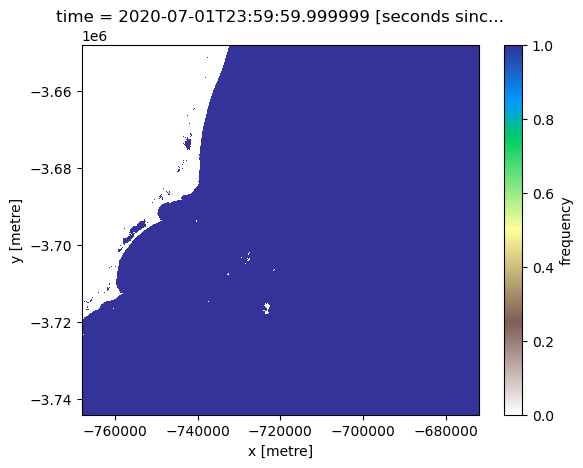

In [23]:
# Load the water observations data over the processed tile and analysis year
wo = dc.load(
    product="ga_ls_wo_fq_cyear_3",
    crs="EPSG:3577",
    output_crs="EPSG:3577",
    x=x_range,
    y=y_range,
    time="2020",
)

# Create water mask to mask pixels that have more than 20% wet observations
# Plot the water mask
wo_mask = wo.frequency > 0.2
wo_mask.plot(cmap="terrain_r")

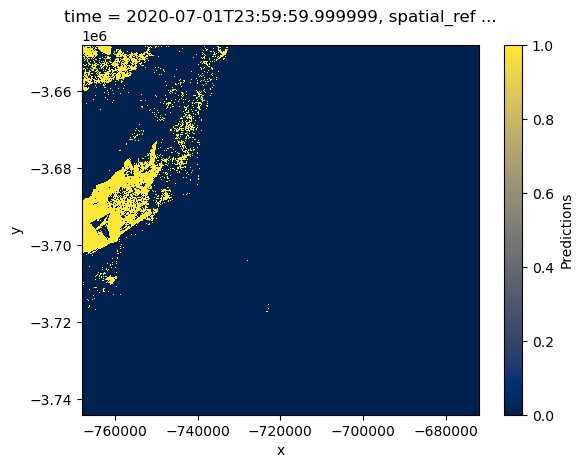

In [24]:
# Mask out pixels from `pedicted` that are frequently inundated using the wo_mask
predicted_wofs = xr.where(wo_mask == 0, predicted, 0)
#Plot the wofs masked `predicted_wofs` Prediction dataarray
predicted_wofs.Predictions.plot(cmap = "cividis")

Text(0.5, 1.0, 'Probabilities')

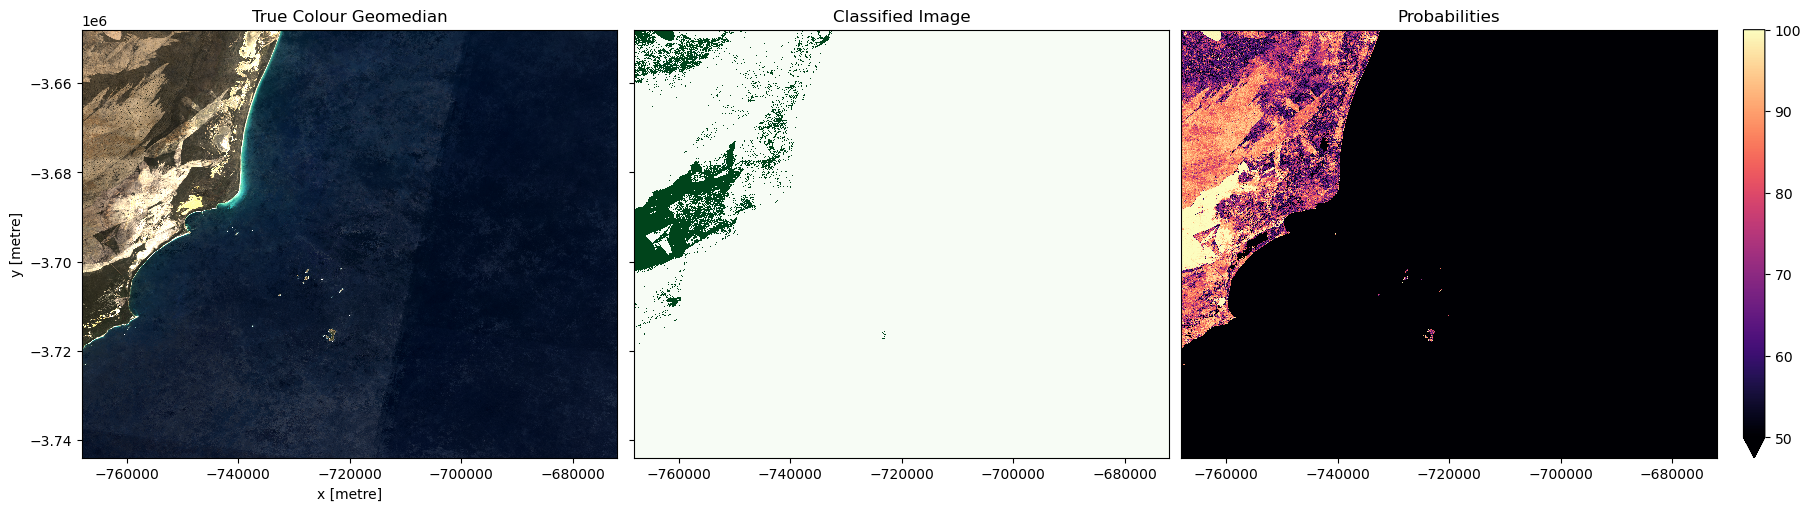

In [26]:
##PLot the tiles RGB for the analysis year, the model preidctions, and probabilities
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, layout="constrained")


# Generate a new datacube query object
query = {
    "resolution": resolution,
    "output_crs": output_crs,
    "x": x_range,
    "y": y_range,
    "crs" : 'EPSG:3577'
}

ds_rgb = dc.load('ga_ls8c_nbart_gm_cyear_3', time = time_post, **query)

# Plot true colour image
rgb(ds_rgb,
    bands=["red", "green", "blue"],
    ax=axes[0],
    percentile_stretch=(0.01, 0.99)
)

# Plot classified image
predicted_wofs.Predictions.plot(
    ax=axes[1], cmap="Greens", add_labels=False, add_colorbar=False
)

predicted_wofs.Probabilities.plot(
    ax=axes[2], cmap="magma", vmin=50, vmax=100, add_labels=False, add_colorbar=True
)

# Remove axis on right plot
axes[2].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title("True Colour Geomedian")
axes[1].set_title("Classified Image")
axes[2].set_title("Probabilities")




### Perform morphological post-processing to remove noise ###

In [27]:
# Define the size of the disk structuring element, measured in number of pixels. 
# The default value is 2.
disk_size = 2

#Remove the time index from the xr dataarray
all_burn = predicted_wofs.Predictions.isel(time=0)

In [28]:
# Perform an opening morphological operation on the `all_burn` dataarray
opened_data = xr.DataArray(
    morphology.binary_opening(all_burn, morphology.disk(disk_size)),
    coords=all_burn.coords,
)
#Perform a closing morphological operation on the `opened_data` dataarray
dilated_data = xr.DataArray(
    ndimage.binary_dilation(opened_data, morphology.disk(disk_size+1)),
    coords=all_burn.coords,
)

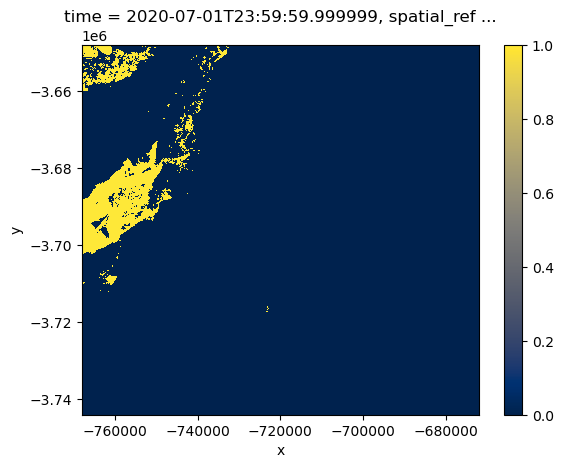

In [29]:
#Set the post-processed data to the `all_burn_cleaned` variable, and convert to a float dtype
all_burn_cleaned = dilated_data
all_burn_cleaned = all_burn_cleaned.astype(int)
all_burn_cleaned = all_burn_cleaned.astype('float64')

#Reapply the wo mask, to remove burnt pixels over water bodies that the above closing created
all_burn_cleaned = xr.where(wo_mask == 0, all_burn_cleaned, 0)

#Ensure the crs attribute is set to 3577 using the wo dc 
all_burn_cleaned.attrs["crs"] = wo.crs

#Plot the cleaned data
all_burn_cleaned.plot(cmap = "cividis")

## 5.Export the Data

### Prepare to save the files

In [30]:
#build dynamic name
nm_sensor = "ls" #from dc.load 
nm_algo = "rf"
nm_yeartype = "cyear" #decision point here
nm_collection = "3"
nm_xy = xy #dynamic build from data loading process
nm_date = "2020" #see what is in bc, based upon nm_yeartype decision from above
nm_output = f'Processed_tiles/ga_{nm_sensor}_{nm_algo}_{nm_yeartype}_{nm_collection}_{nm_xy}_{nm_date}_demo.tif'



### Generate Rasters

In [31]:
write_cog(geo_im=all_burn_cleaned,
          fname=nm_output,
          overwrite=True,
          nodata=-999)

PosixPath('Processed_tiles/ga_ls_rf_cyear_3_x20y18_2020_demo.tif')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2023

**Compatible datacube version:** 

In [32]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)